# Ikeda eddy damping

# Purpose
Investigate the implementation of the eddy damping 

# Methodology
Following the sectional eddy damping published in <cite data-cite="7505983/4AFVVGNT"></cite>.

![](ikeda_eddy_section_A.PNG)
<div class="cite2c-biblio"></div>

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

#%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from rolldecayestimators import ikeda_speed
from rolldecayestimators.ikeda_naked import eddy_sections
import rolldecayestimators.ikeda_naked as ikeda_naked
#from rolldecayestimators.ikeda_speed import eddy_sections

from rolldecayestimators import simplified_ikeda
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from src.helpers import calculate_lewis,calculate_B_star_hat,estimate_bilge_radius, estimate_sigma

# Load digitalized ikeda results

In [3]:
import json

def load_digitalized(file_path:str):
    
    with open(file_path, mode='r') as file:
        j = json.load(file)
    
    df = pd.DataFrame()
    for dataset in j['datasetColl']:
        df_ = load_dataset(dataset=dataset)
        df = df.append(df_)
        
    return df

def load_dataset(dataset):
    
    name = dataset['name']
    
    xs = []
    ys = []
    for data in dataset['data']:
        x = float(data['value'][0])
        y = float(data['value'][1])
        xs.append(x)
        ys.append(y)
        
    df = pd.DataFrame()
    df['x'] = xs
    df['y'] = ys
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    
    df['name'] = name
    
    return df

In [4]:
file_paths = {
'A': '../data/external/ikeda_eddy_section_A_phi_a.json',
'B': '../data/external/ikeda_eddy_section_B_phi_a.json',
'C': '../data/external/ikeda_eddy_section_C_phi_a.json',
'D': '../data/external/ikeda_eddy_section_D_phi_a.json',
'G': '../data/external/ikeda_eddy_section_G_phi_a.json',
'H': '../data/external/ikeda_eddy_section_H_phi_a.json',
'I': '../data/external/ikeda_eddy_section_I_phi_a.json',
'J': '../data/external/ikeda_eddy_section_J_phi_a.json',
'K': '../data/external/ikeda_eddy_section_K_phi_a.json',
'L': '../data/external/ikeda_eddy_section_L_phi_a.json',
}

df_paper = pd.DataFrame()
for model, file_path in file_paths.items():
    df_ = load_digitalized(file_path=file_path)
    df_['model']=model
    df_paper = df_paper.append(df_)

df_paper.rename(columns={
    'x':'phi_a',
    'y':'B_star_hat',
    'name':'w_hat',
    }, inplace=True)

df_paper['w_hat'] = df_paper['w_hat'].astype(float)
df_paper['phi_a'] = df_paper['phi_a'].round(decimals=2)

In [5]:
def B_W_B_F(row):
    mask = ((df_paper.model == row.model) & (df_paper.phi_a==0) & (df_paper.w_hat == row.w_hat))
    df_origo = df_paper.loc[mask]
    if len(df_origo)==0:
        return None
    elif len(df_origo)==1:
        origo = df_origo.iloc[0]
    else:
        raise ValueError('Too many...')
    
    B = origo['B_star_hat']
    return B

In [6]:
df_paper['B_W+B_F'] = df_paper.apply(func=B_W_B_F, axis=1)
df_paper['B_e_star_hat'] = df_paper['B_star_hat'] - df_paper['B_W+B_F']
mask = df_paper['phi_a'] != 0
df_paper = df_paper.loc[mask].copy()  # Dropping the zeros

In [7]:
df_paper

,phi_a,B_star_hat,w_hat,model,B_W+B_F,B_e_star_hat
1,0.23,0.041169,0.751,A,0.003636,0.037534
1,0.24,0.029803,0.507,A,0.001391,0.028413
1,0.30,0.023966,0.751,B,0.003265,0.020700
1,0.30,0.014438,0.536,B,0.001111,0.013328
1,0.27,0.008265,0.751,C,0.002115,0.006151
1,0.21,0.005487,0.625,C,0.001500,0.003987
1,0.31,0.009504,0.939,D,0.002039,0.007466
1,0.31,0.007645,0.751,D,0.001500,0.006145
1,0.24,0.099861,0.814,G,0.088356,0.011505
1,0.30,0.002040,0.560,H,0.001400,0.000640


In [8]:
df = pd.read_csv('../data/external/ikeda_eddy._sections.csv', sep=';', index_col=0)
df.head()

,L,B,d,volume,H0,sigma,OG/d,R
No,,,,,,,,
A,0.8,0.280,0.112,0.02509,1.250,1.000,0.000,0.00
B,0.8,0.280,0.112,0.02501,1.250,0.997,0.000,0.01
C,0.8,0.280,0.112,0.02495,1.250,0.995,0.000,0.02
D,0.8,0.280,0.112,0.02475,1.250,0.988,0.000,0.03
E,0.8,0.024,0.070,0.00116,0.171,0.866,-1.753,NaN


# Model A

In [9]:
parameters = df.loc['A']

In [10]:
sigma = parameters.sigma
B_s = np.array([parameters.B])
T_s = parameters.d
S_s = sigma*B_s*T_s
a, a_1, a_3, sigma_s, H = ikeda_speed.calculate_sectional_lewis(B_s=B_s, T_s=T_s, S_s=S_s)

## Journee limits

In [11]:
H

array([1.25])

In [12]:
sigma_min = 3*np.pi/32*(2-1/H)
sigma_min

array([0.35342917])

In [13]:
sigma_max = np.pi/32*(10 + H + 1/H)
sigma_max

array([1.18300598])

It is obvious that a transformation of a half immersed circle with radius R will result in
Ms = R, a1 = 0 and a3 = 0.

In [14]:
ikeda_speed.calculate_sectional_lewis(B_s=2, T_s=1, S_s=np.pi/2)

(array([1.]), array([0.]), array([0.]), array([0.78539816]), array([1.]))

In [15]:
OG=parameters['OG/d']*parameters.d
R = parameters.R 

g = 9.81
rho = 1000

fi_a = 0.175
w_hats = np.linspace(0,1.0,10)

w = lambdas.omega_from_hat(beam=parameters.B, g=g, omega_hat=w_hats)

B_E0_s = eddy_sections(bwl=B_s, a_1=a_1, a_3=a_3, sigma=sigma_s, H0=H, Ts=T_s,
         OG=OG, R=R, wE=w, fi_a=fi_a, ra=1000.0)

B_E0 = B_E0_s*parameters.L

Disp = parameters.volume
B_E0_hat = lambdas.B_to_hat_lambda(B=B_E0, Disp=Disp, beam=B_s, g=g, rho=rho)
B_E0_star_hat = B_E0_hat*3*np.pi/8


In [16]:
B_E0_star_hat

array([[0.        , 0.00297258, 0.00594516, 0.00891774, 0.01189032,
        0.0148629 , 0.01783548, 0.02080806, 0.02378064, 0.02675322]])

<IPython.core.display.Javascript object>


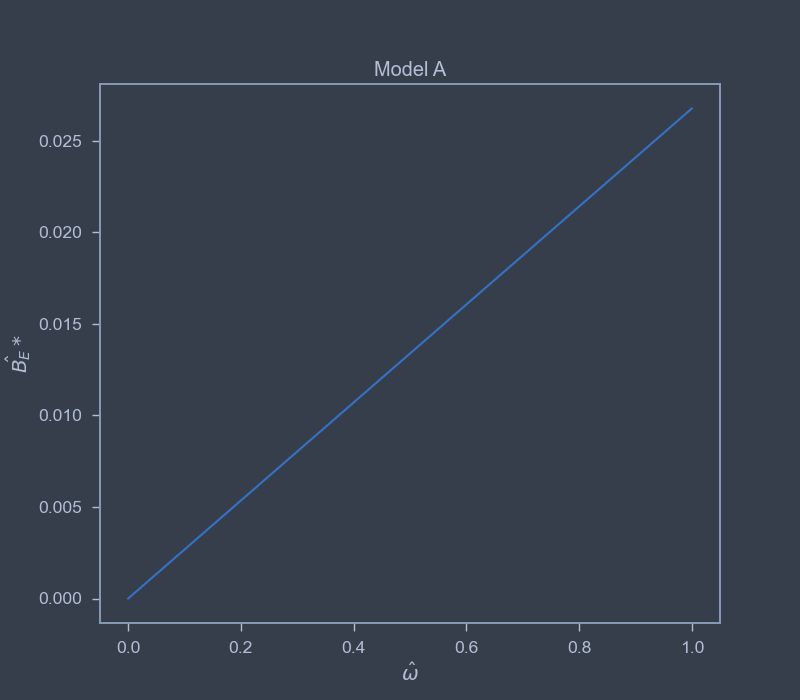

Text(0, 0.5, '$\\hat{B_E}*$')

In [17]:
fig,ax=plt.subplots()
ax.plot(w_hats, B_E0_star_hat[0])
ax.set_title('Model A')
ax.set_xlabel(r'$\hat{\omega}$')
ax.set_ylabel(r'$\hat{B_E}*$')

<IPython.core.display.Javascript object>


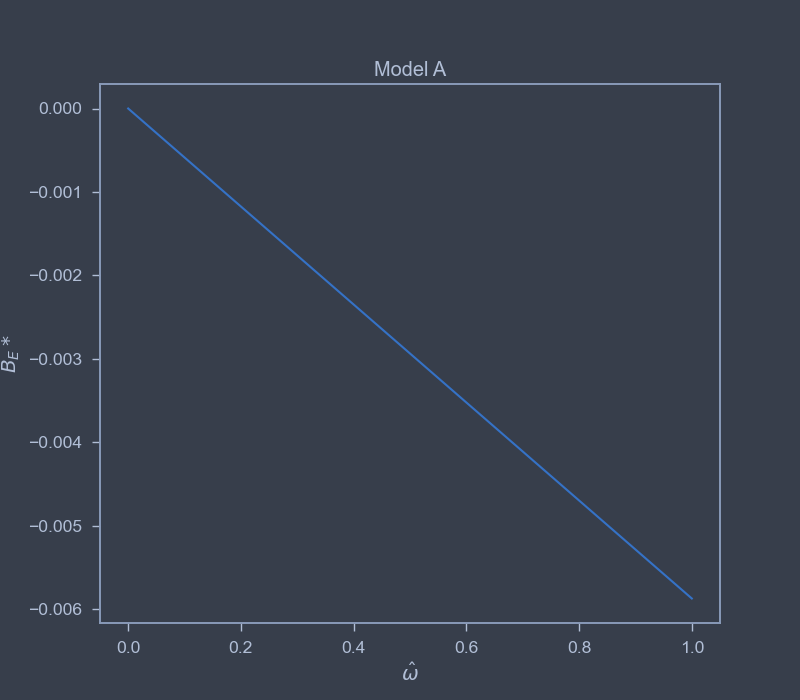

Text(0, 0.5, '$\\hat{B_E}*$')

In [18]:
OG=parameters['OG/d']*parameters.d
R = parameters.R 

g = 9.81
rho = 1000

fi_a = 0.175
w_hats = np.linspace(0,1.0,10)

w = lambdas.omega_from_hat(beam=parameters.B, g=g, omega_hat=w_hats)

BD = parameters['B']/parameters['d']
CB = parameters.volume/(parameters.L*parameters.B*parameters.d)
OGD = OG/parameters.d
PHI = np.rad2deg(fi_a)
B_E0_s = simplified_ikeda.calculate_B_E(BD=BD, CB=CB, CMID=parameters.sigma, OGD=OGD, OMEGAHAT=w_hats,
                                        PHI=PHI)

fig,ax=plt.subplots()
ax.plot(w_hats, B_E0_s)
ax.set_title('Model A')
ax.set_xlabel(r'$\hat{\omega}$')
ax.set_ylabel(r'$\hat{B_E}*$')

In [19]:
df

,L,B,d,volume,H0,sigma,OG/d,R
No,,,,,,,,
A,0.8,0.280,0.112,0.02509,1.2500,1.000,0.000,0.00
B,0.8,0.280,0.112,0.02501,1.2500,0.997,0.000,0.01
C,0.8,0.280,0.112,0.02495,1.2500,0.995,0.000,0.02
D,0.8,0.280,0.112,0.02475,1.2500,0.988,0.000,0.03
E,0.8,0.024,0.070,0.00116,0.1710,0.866,-1.753,NaN
F,0.8,0.064,0.150,0.00763,0.2100,0.992,-0.800,NaN
G,0.8,0.185,0.192,0.02321,0.4850,0.799,0.000,NaN
H,0.8,0.398,0.193,0.05490,1.0360,0.893,0.000,NaN
I,0.8,0.237,0.096,0.01775,1.2320,0.977,0.000,NaN


In [20]:
df_paper_data = pd.merge(left=df_paper, right=df, how='left', left_on='model', right_index=True)
df_paper_data.reset_index(inplace=True, drop=True)
df_paper_data.to_csv('../data/interim/ikeda_sections.csv')

## Calculate Lewis coefficients

In [21]:
a, a_1, a_3, sigma_s, H = calculate_lewis(df_paper_data)
df_paper_data['a_1'] = a_1
df_paper_data['a_3'] = a_3
df_paper_data['H0'] = H

In [22]:
mask = df_paper_data['R'].isnull()
df_paper_data.loc[mask,'R'] = estimate_bilge_radius(**df_paper_data.loc[mask])

In [23]:
df_paper_data

,phi_a,B_star_hat,w_hat,model,B_W+B_F,B_e_star_hat,L,B,d,volume,H0,sigma,OG/d,R,a_1,a_3
0,0.23,0.041169,0.751,A,0.003636,0.037534,0.8,0.280,0.112,0.02509,1.250000,1.000,0.0,0.000000,0.095721,-0.138514
1,0.24,0.029803,0.507,A,0.001391,0.028413,0.8,0.280,0.112,0.02509,1.250000,1.000,0.0,0.000000,0.095721,-0.138514
2,0.30,0.023966,0.751,B,0.003265,0.020700,0.8,0.280,0.112,0.02501,1.250000,0.997,0.0,0.010000,0.095950,-0.136454
3,0.30,0.014438,0.536,B,0.001111,0.013328,0.8,0.280,0.112,0.02501,1.250000,0.997,0.0,0.010000,0.095950,-0.136454
4,0.27,0.008265,0.751,C,0.002115,0.006151,0.8,0.280,0.112,0.02495,1.250000,0.995,0.0,0.020000,0.096102,-0.135084
5,0.21,0.005487,0.625,C,0.001500,0.003987,0.8,0.280,0.112,0.02495,1.250000,0.995,0.0,0.020000,0.096102,-0.135084
6,0.31,0.009504,0.939,D,0.002039,0.007466,0.8,0.280,0.112,0.02475,1.250000,0.988,0.0,0.030000,0.096632,-0.130314
7,0.31,0.007645,0.751,D,0.001500,0.006145,0.8,0.280,0.112,0.02475,1.250000,0.988,0.0,0.030000,0.096632,-0.130314
8,0.24,0.099861,0.814,G,0.088356,0.011505,0.8,0.185,0.192,0.02321,0.481771,0.799,0.0,0.182397,-0.347078,-0.007600
9,0.30,0.002040,0.560,H,0.001400,0.000640,0.8,0.398,0.193,0.05490,1.031088,0.893,0.0,0.195702,0.014252,-0.068862


In [24]:
#df_paper_data['B_e_star_hat_pred'] = df_paper_data.apply(func=calculate_B_star_hat, axis=1)

In [25]:
df_paper_data['B_e_star_hat_pred'] = calculate_B_star_hat(df_paper_data)

In [26]:
df_paper_data

,phi_a,B_star_hat,w_hat,model,B_W+B_F,B_e_star_hat,L,B,d,volume,H0,sigma,OG/d,R,a_1,a_3,B_e_star_hat_pred
0,0.23,0.041169,0.751,A,0.003636,0.037534,0.8,0.280,0.112,0.02509,1.250000,1.000,0.0,0.000000,0.095721,-0.138514,2.640619e-02
1,0.24,0.029803,0.507,A,0.001391,0.028413,0.8,0.280,0.112,0.02509,1.250000,1.000,0.0,0.000000,0.095721,-0.138514,1.860190e-02
2,0.30,0.023966,0.751,B,0.003265,0.020700,0.8,0.280,0.112,0.02501,1.250000,0.997,0.0,0.010000,0.095950,-0.136454,7.631268e-03
3,0.30,0.014438,0.536,B,0.001111,0.013328,0.8,0.280,0.112,0.02501,1.250000,0.997,0.0,0.010000,0.095950,-0.136454,5.446551e-03
4,0.27,0.008265,0.751,C,0.002115,0.006151,0.8,0.280,0.112,0.02495,1.250000,0.995,0.0,0.020000,0.096102,-0.135084,8.507536e-04
5,0.21,0.005487,0.625,C,0.001500,0.003987,0.8,0.280,0.112,0.02495,1.250000,0.995,0.0,0.020000,0.096102,-0.135084,5.506801e-04
6,0.31,0.009504,0.939,D,0.002039,0.007466,0.8,0.280,0.112,0.02475,1.250000,0.988,0.0,0.030000,0.096632,-0.130314,3.350801e-04
7,0.31,0.007645,0.751,D,0.001500,0.006145,0.8,0.280,0.112,0.02475,1.250000,0.988,0.0,0.030000,0.096632,-0.130314,2.679927e-04
8,0.24,0.099861,0.814,G,0.088356,0.011505,0.8,0.185,0.192,0.02321,0.481771,0.799,0.0,0.182397,-0.347078,-0.007600,9.716108e-04
9,0.30,0.002040,0.560,H,0.001400,0.000640,0.8,0.398,0.193,0.05490,1.031088,0.893,0.0,0.195702,0.014252,-0.068862,-4.042442e-07


In [27]:
df_paper_data_ = df_paper_data.copy()
#df_paper_data_['phi_a'] = np.rad2deg(df_paper_data_['phi_a'])

<IPython.core.display.Javascript object>


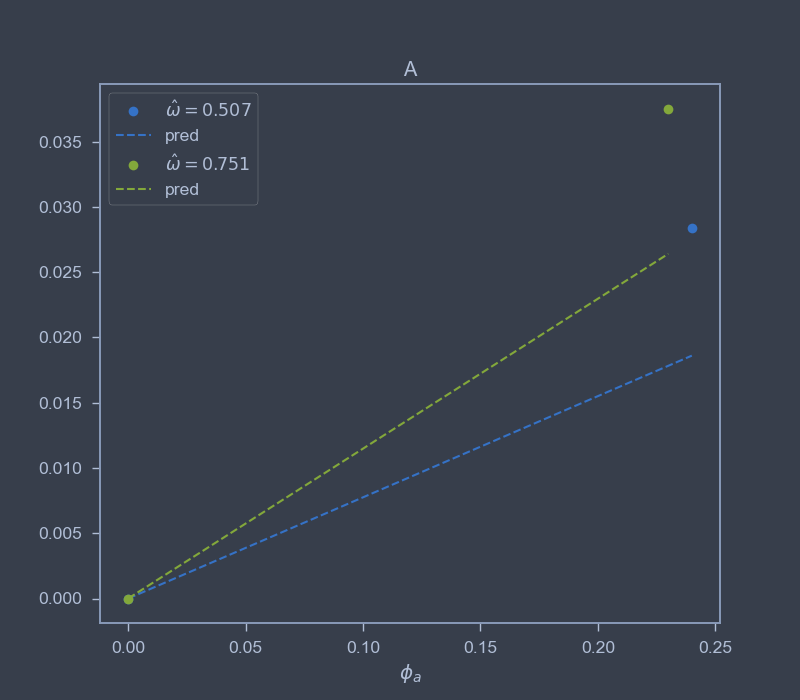

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


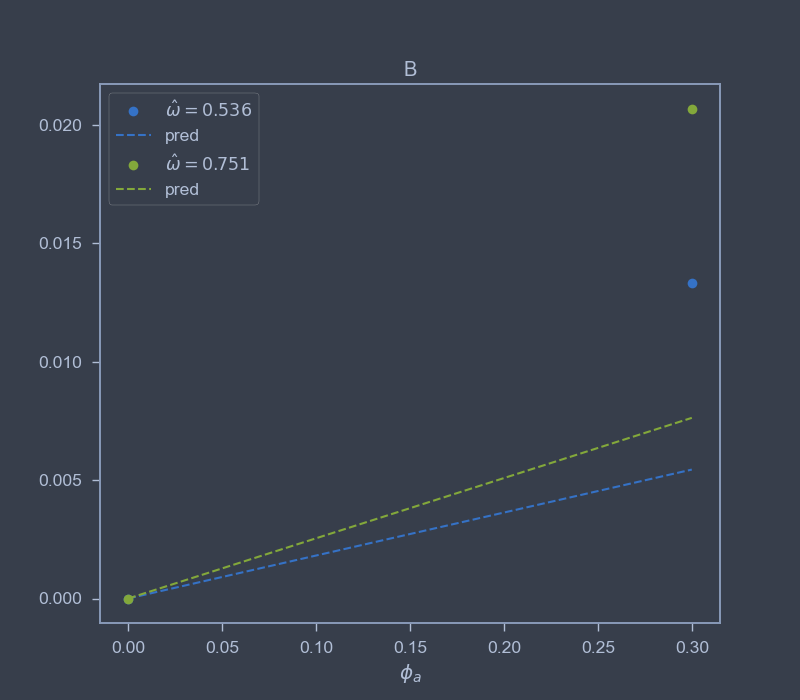

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


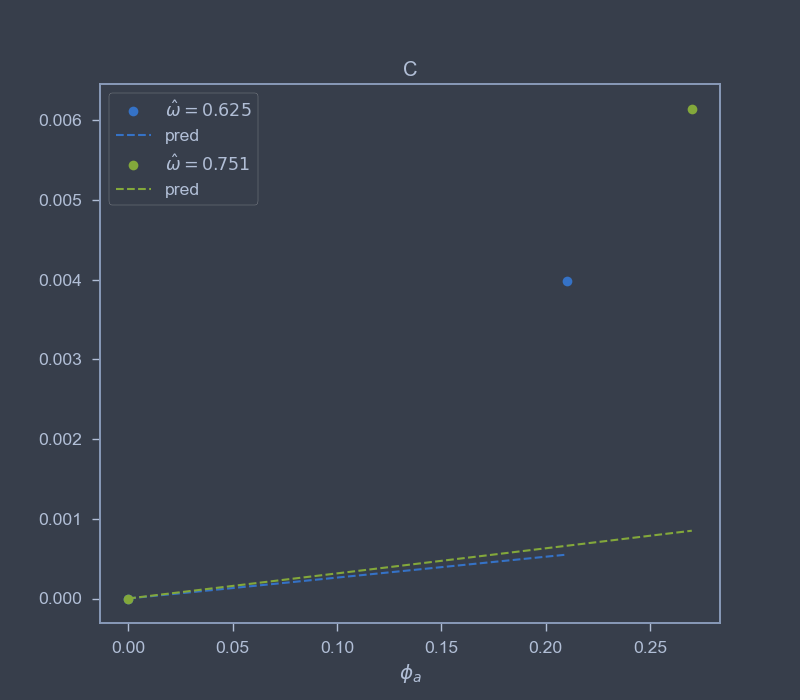

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


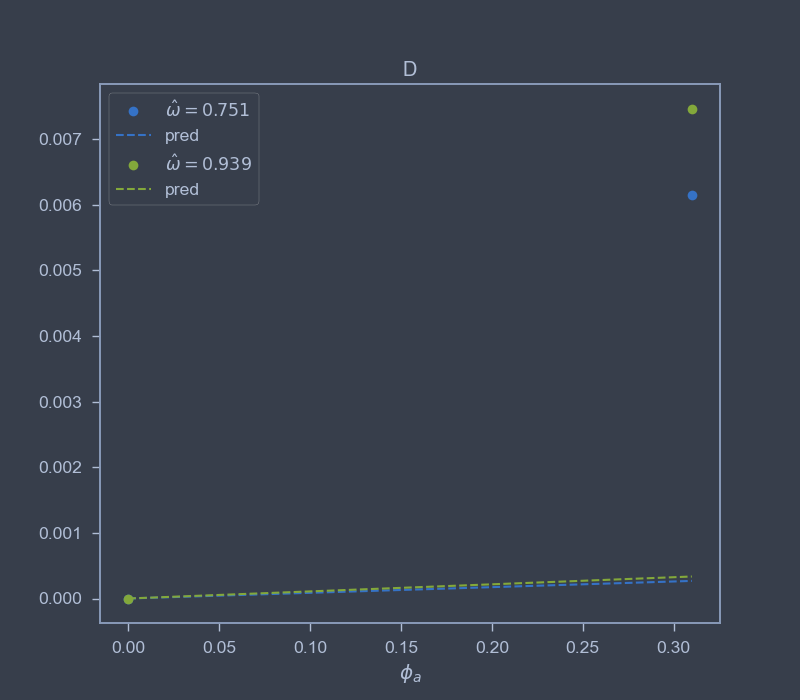

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


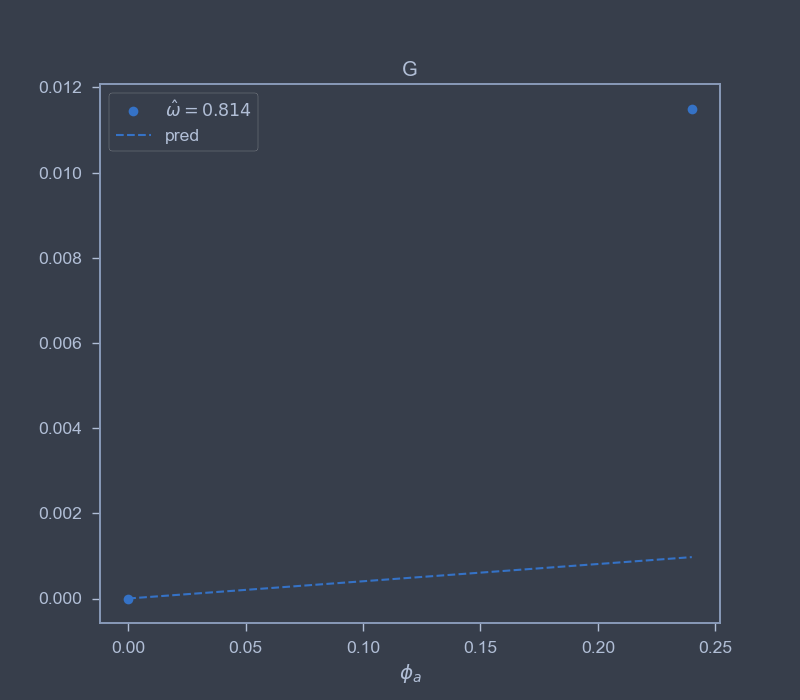

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


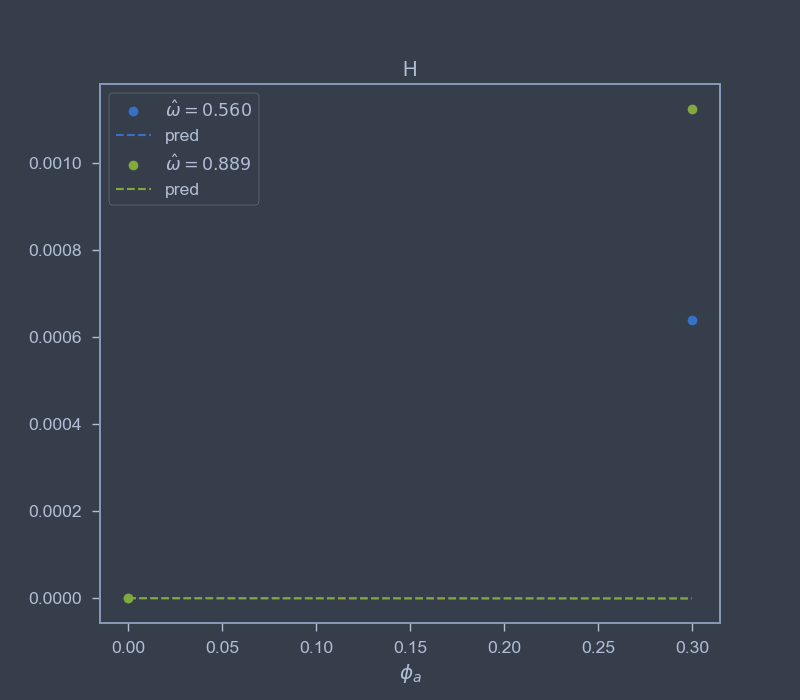

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


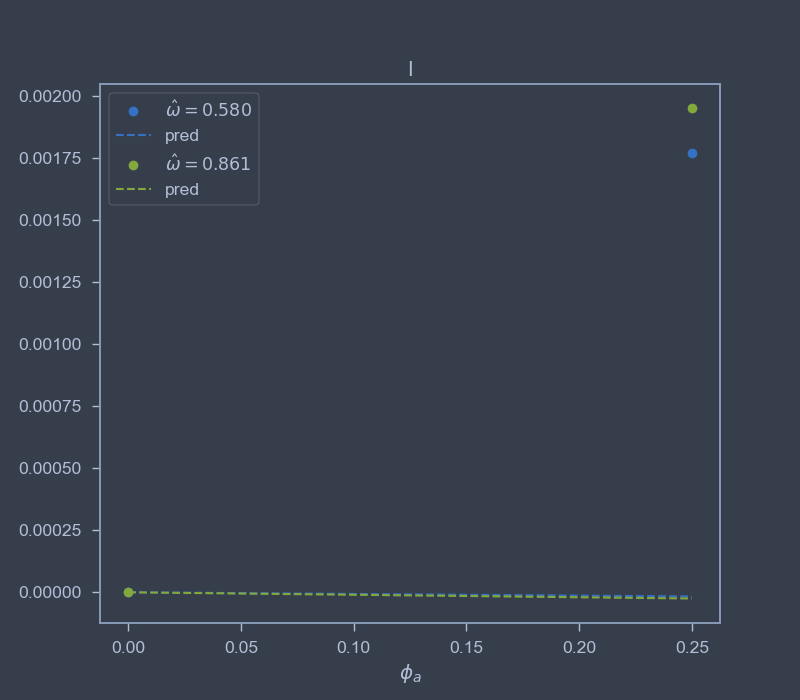

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


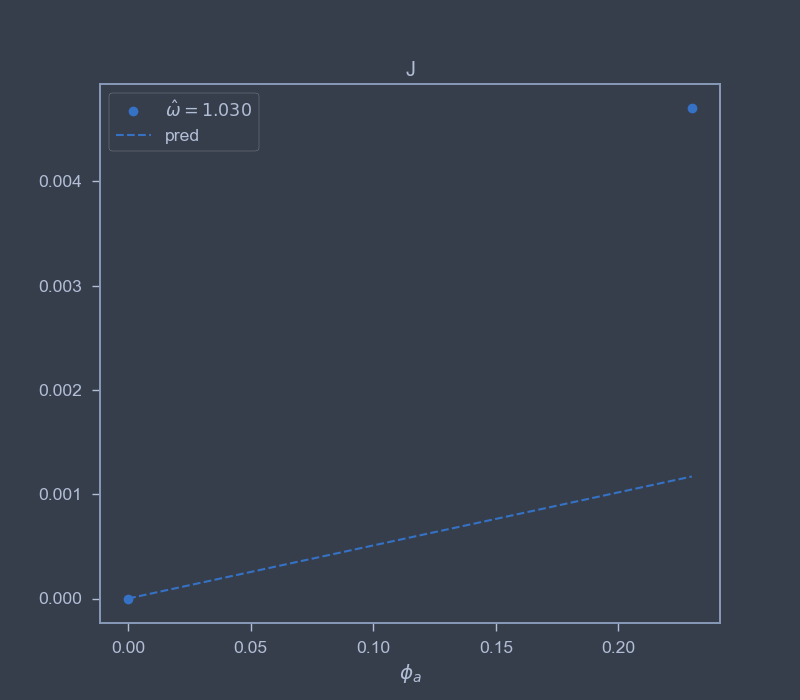

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


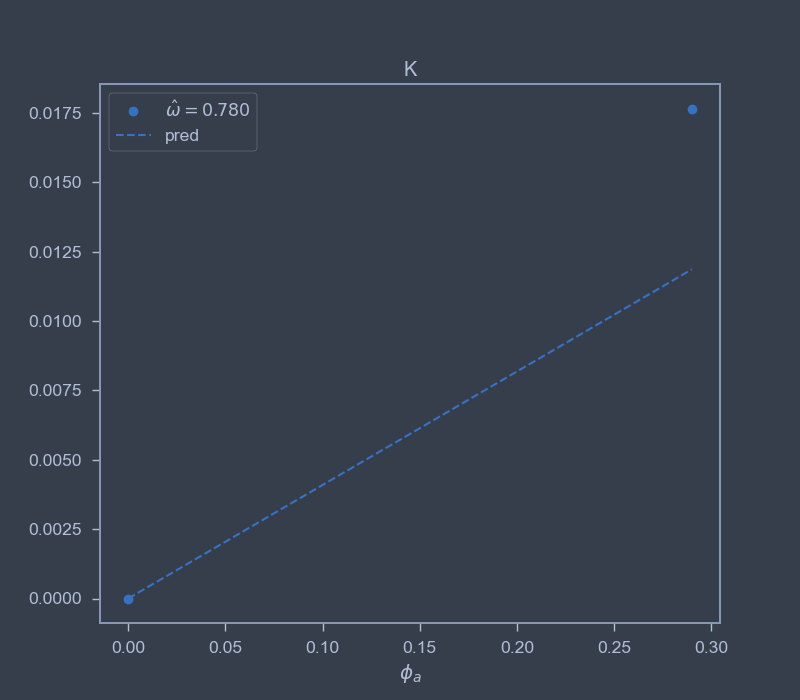

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


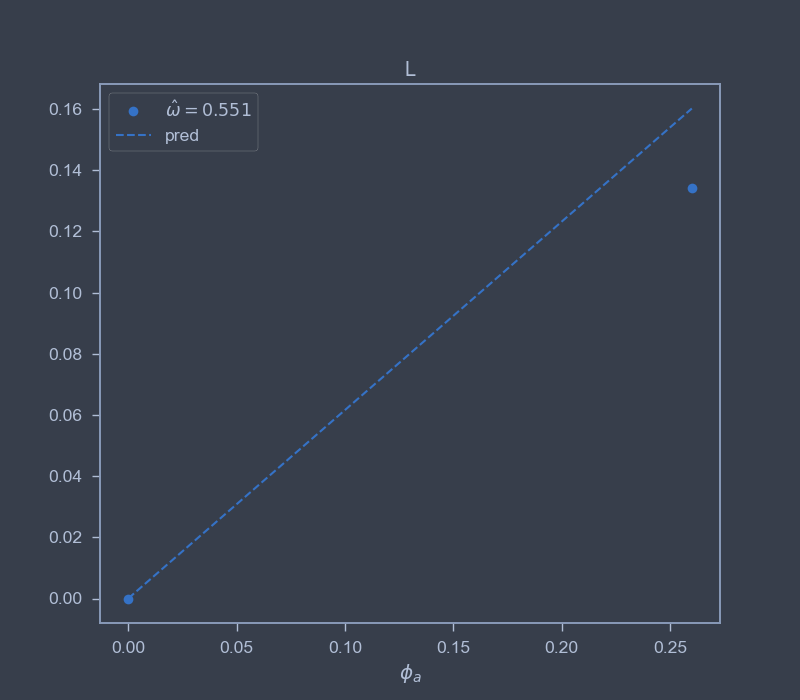

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [28]:
for model_name, model_data in df_paper_data.groupby(by='model'):
    fig,ax=plt.subplots()
    for w_hat, df_ in model_data.groupby(by='w_hat'):
        label = '$\hat{\omega}=%0.3f$' % w_hat
        x = df_['phi_a']
        y = df_['B_e_star_hat']
        lines = ax.plot([0,x], [0,y], 'o', label=label)
        line = lines[-1]
        color = line.get_color()
                
        N=20
        model = df_.select_dtypes(exclude='object').iloc[0]
        data = np.tile(model,(N,1))
        df_pred = pd.DataFrame(data=data, columns=model.index)
        df_pred['phi_a'] = np.linspace(0,model.phi_a,N)
        #df_pred['B_e_star_hat_pred'] = df_pred.apply(func=calculate_B_star_hat, axis=1)
        df_pred['B_e_star_hat_pred'] = calculate_B_star_hat(parameters=df_pred)
        df_pred.plot(x='phi_a', y='B_e_star_hat_pred', style='--', color=color, label='pred', ax=ax)
        
    ax.set_xlabel('$\phi_a$')
    ax.legend()
    ax.set_title(model_name)

In [29]:
OG = df_paper_data['OG/d']*df_paper_data.d
ra = 1000
df_paper_data['C_r'] = ikeda_naked.calculate_C_r(bwl=df_paper_data.B,
                          a_1=df_paper_data.a_1, a_3=df_paper_data.a_3, sigma=df_paper_data.sigma, 
                                             H0=df_paper_data.H0, d=df_paper_data.d, OG=OG, 
                          R=df_paper_data.R, ra=ra)

In [30]:
df_paper_data

,phi_a,B_star_hat,w_hat,model,B_W+B_F,B_e_star_hat,L,B,d,volume,H0,sigma,OG/d,R,a_1,a_3,B_e_star_hat_pred,C_r
0,0.23,0.041169,0.751,A,0.003636,0.037534,0.8,0.280,0.112,0.02509,1.250000,1.000,0.0,0.000000,0.095721,-0.138514,2.640619e-02,4.777742
1,0.24,0.029803,0.507,A,0.001391,0.028413,0.8,0.280,0.112,0.02509,1.250000,1.000,0.0,0.000000,0.095721,-0.138514,1.860190e-02,4.777742
2,0.30,0.023966,0.751,B,0.003265,0.020700,0.8,0.280,0.112,0.02501,1.250000,0.997,0.0,0.010000,0.095950,-0.136454,7.631268e-03,1.055196
3,0.30,0.014438,0.536,B,0.001111,0.013328,0.8,0.280,0.112,0.02501,1.250000,0.997,0.0,0.010000,0.095950,-0.136454,5.446551e-03,1.055196
4,0.27,0.008265,0.751,C,0.002115,0.006151,0.8,0.280,0.112,0.02495,1.250000,0.995,0.0,0.020000,0.096102,-0.135084,8.507536e-04,0.130393
5,0.21,0.005487,0.625,C,0.001500,0.003987,0.8,0.280,0.112,0.02495,1.250000,0.995,0.0,0.020000,0.096102,-0.135084,5.506801e-04,0.130393
6,0.31,0.009504,0.939,D,0.002039,0.007466,0.8,0.280,0.112,0.02475,1.250000,0.988,0.0,0.030000,0.096632,-0.130314,3.350801e-04,0.035488
7,0.31,0.007645,0.751,D,0.001500,0.006145,0.8,0.280,0.112,0.02475,1.250000,0.988,0.0,0.030000,0.096632,-0.130314,2.679927e-04,0.035488
8,0.24,0.099861,0.814,G,0.088356,0.011505,0.8,0.185,0.192,0.02321,0.481771,0.799,0.0,0.182397,-0.347078,-0.007600,9.716108e-04,0.007268
9,0.30,0.002040,0.560,H,0.001400,0.000640,0.8,0.398,0.193,0.05490,1.031088,0.893,0.0,0.195702,0.014252,-0.068862,-4.042442e-07,-0.000038


In [31]:
df_paper_data['k'] = df_paper_data['B_e_star_hat']/df_paper_data['phi_a']
df_paper_data['k_pred'] = df_paper_data['B_e_star_hat_pred']/df_paper_data['phi_a']

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


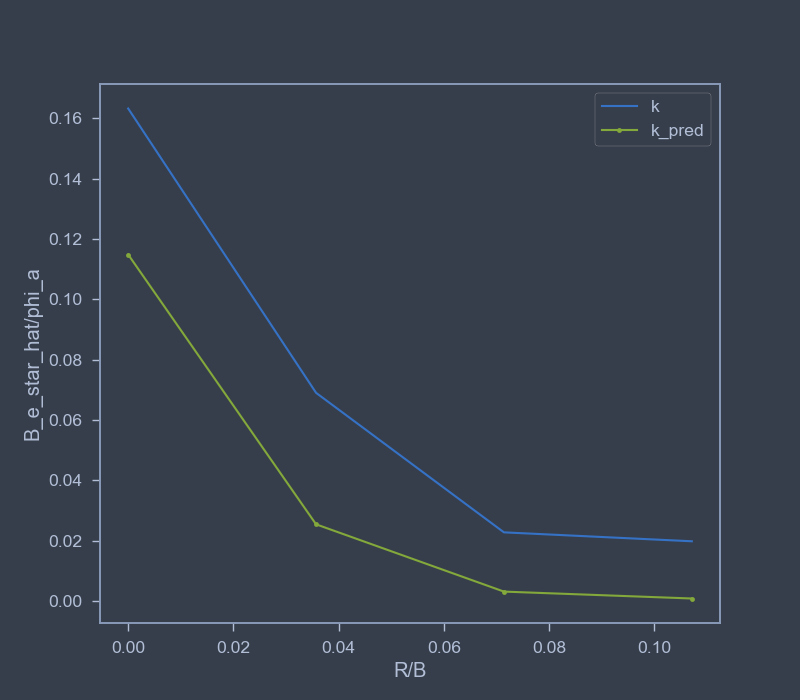

Text(0, 0.5, 'B_e_star_hat/phi_a')

In [32]:
mask = (df_paper_data['w_hat'] == 0.751)
df_changes = df_paper_data.loc[mask]
#df_changes['k_corr'] = df_changes['k_pred'] + 0.04
df_changes['R/B'] = df_changes['R']/df_changes['B']
fig,ax=plt.subplots()
df_changes.plot(x='R/B', y='k', ax=ax)
df_changes.plot(x='R/B', y='k_pred', style='.-', ax=ax)
#df_changes.plot(x='R/B', y='k_corr', ax=ax)
ax.set_xlabel('R/B')
ax.set_ylabel('B_e_star_hat/phi_a')


<IPython.core.display.Javascript object>


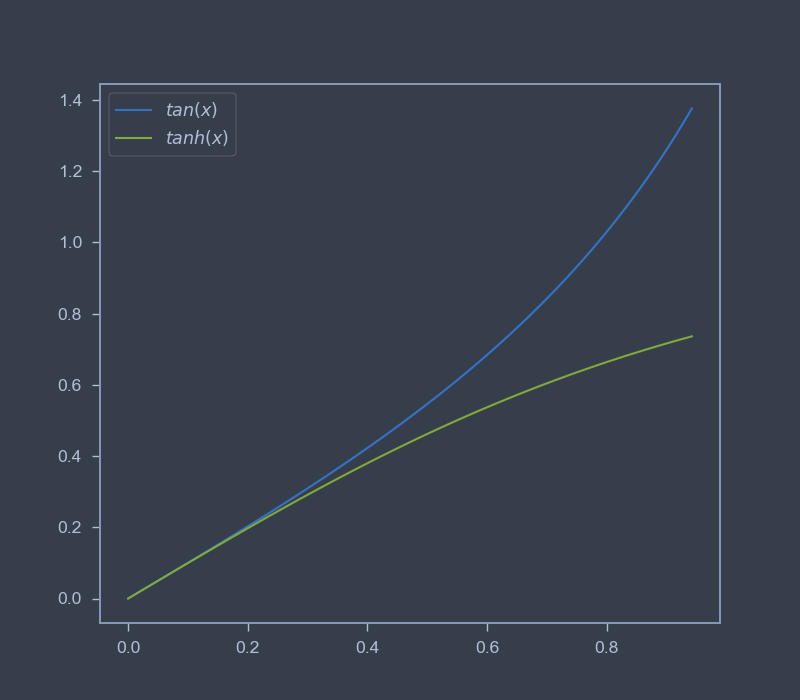

In [33]:
x = np.linspace(0,0.3*np.pi,100)
fig,ax=plt.subplots()
ax.plot(x,np.tan(x), label='$tan(x)$')
ax.plot(x,np.tanh(x), label='$tanh(x)$')
ax.legend()


<IPython.core.display.Javascript object>


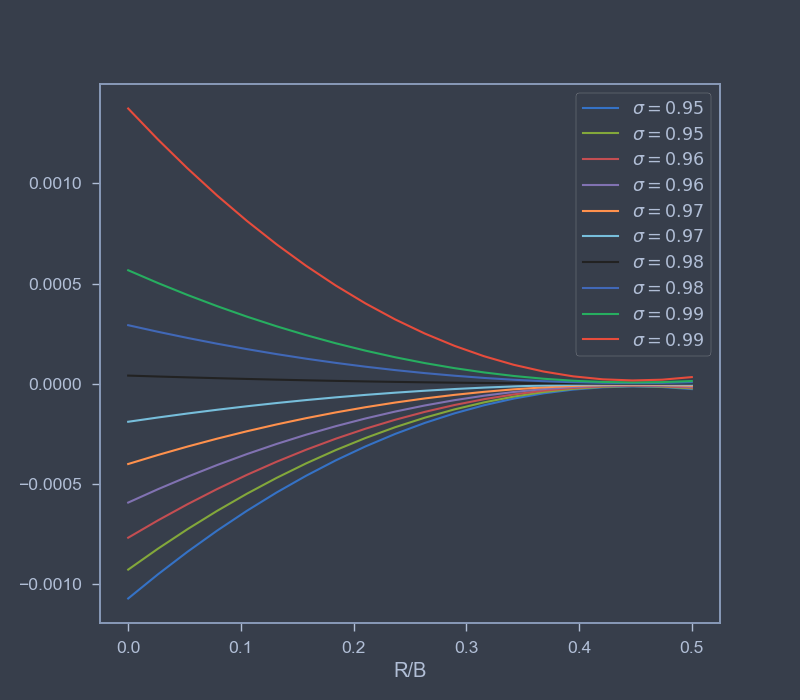

In [34]:
model = df.loc['C']
model['w_hat'] = 0.751
model['phi_a'] = 0.31

N=20
data = np.tile(model,(N,1))
df_ = pd.DataFrame(data=data, columns=model.index)
df_['R/B'] = np.linspace(0,1/2,N)
df_['R'] = model.B*df_['R/B']
df_.set_index('R/B', inplace=True)

fig,ax=plt.subplots()
N=10
for sigma in np.linspace(0.95,0.995,N):
    df_['sigma'] = sigma
    df_['B_e_star_hat_pred'] = calculate_B_star_hat(df_)
    label = '$\sigma=%0.2f$' % sigma
    df_.plot(y='B_e_star_hat_pred', label = label, ax=ax)


In [35]:
import matplotlib.patches

def plot_simplified_section(fig, model, xy=(.25, .70)):
    
    ax = fig.add_axes([xy[0], xy[1], .10, .10], zorder=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
    B2 = model.B/2    
    x1 = B2-model.R
    rectangle_1 = matplotlib.patches.Rectangle((0,0), x1, model.d, angle=0.0)
    
    y1 = model.R
    h1 = model.d - model.R
    rectangle_2 = matplotlib.patches.Rectangle((0,y1), B2, h1, angle=0.0)
    
    bilge = matplotlib.patches.Wedge((x1,y1), r=model.R, theta1=270, theta2=360)
    
    ax.add_patch(rectangle_1)
    ax.add_patch(rectangle_2)
    ax.add_patch(bilge)
    
    ax.set_xlim(0,B2)
    ax.set_ylim(0,model.d)
    
    

<IPython.core.display.Javascript object>


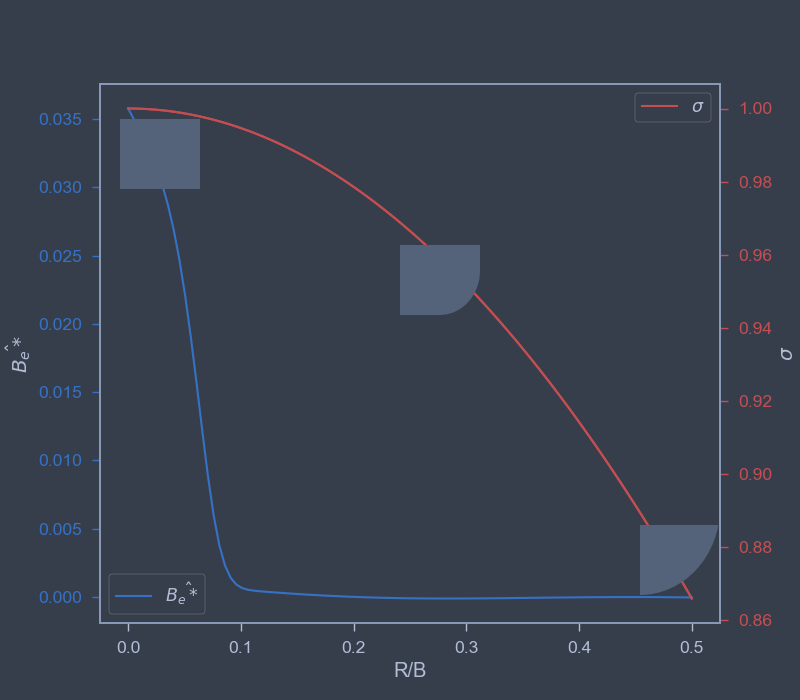

Text(0, 0.5, '$\\sigma$')

In [36]:
model = df.loc['C']
model['w_hat'] = 0.751
model['phi_a'] = 0.31

N=100
data = np.tile(model,(N,1))
df_ = pd.DataFrame(data=data, columns=model.index)
df_['R/B'] = np.linspace(0,1/2,N)
df_['R'] = model.B*df_['R/B']
df_['sigma'] = estimate_sigma(b=df_['B'],t=df_['d'],R=df_['R'])
df_.set_index('R/B', inplace=True)

fig,ax=plt.subplots()
plot_simplified_section(fig=fig, model=df_.iloc[0], xy=(0.15,0.73))
plot_simplified_section(fig=fig, model=df_.iloc[50], xy=(0.5,0.55))
plot_simplified_section(fig=fig, model=df_.iloc[99], xy=(0.8,0.15))

label=r'$\hat{B_e*}$'
ax.set_ylabel(label)
ax.tick_params(axis='y', colors='b')
df_['B_e_star_hat_pred'] = calculate_B_star_hat(df_)
df_.plot(y='B_e_star_hat_pred', label=label, ax=ax, zorder=10)
ax.legend(loc='lower left')

ax_sigma = ax.twinx()
ax_sigma.tick_params(axis='y', colors='r')
label=r'$\sigma$'
df_.plot(y='sigma', style='r-', label=label, ax=ax_sigma, zorder=20)
ax_sigma.plot(df_.index,df_['sigma'], 'r-', label=label, zorder=20)
ax_sigma.set_ylabel(label)



In [37]:
model = df.loc['A'].copy()
model['w_hat'] = 0.751
model['phi_a'] = 0.31
a, a_1, a_3, sigma_s, H = calculate_lewis(model)
OG=model['OG/d']*model.d
gamma, r_max = ikeda_naked.calculate_gamma(sigma=model.sigma, OG=OG, d=model.d, a_1=a_1, a_3=a_3, H0=H, bwl=model.B)
gamma

array([5.83618791])

<IPython.core.display.Javascript object>


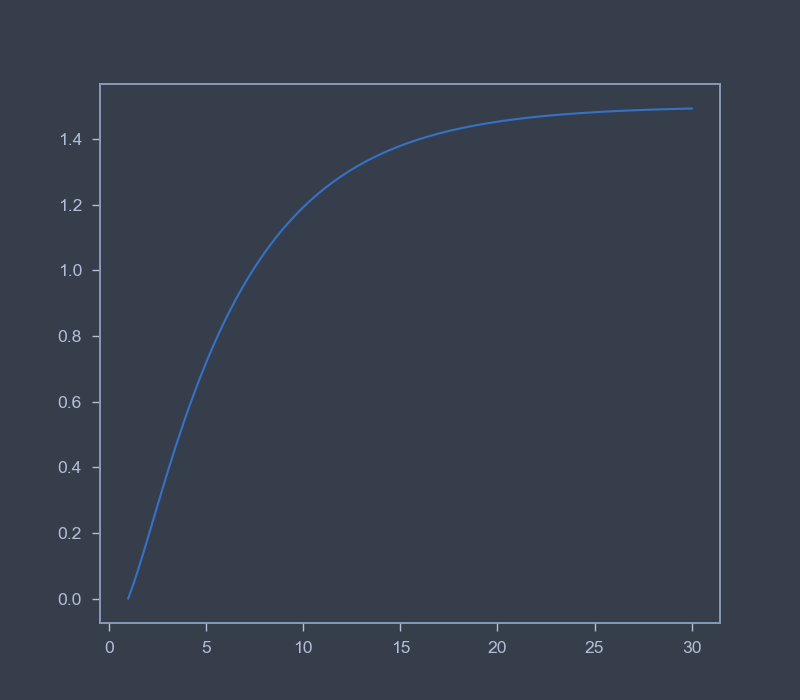

In [38]:
gammas = np.linspace(1,30,100)
C_p = ikeda_naked.calculate_C_p(gammas)
fig,ax=plt.subplots()
ax.plot(gammas, C_p)

<IPython.core.display.Javascript object>


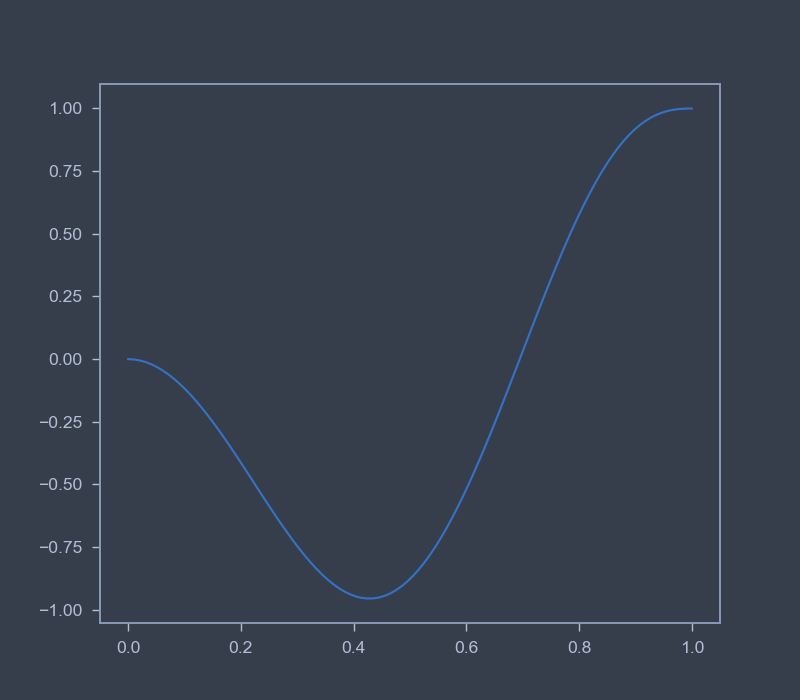

In [39]:
sigmas = np.linspace(0,1,100)
f_2s = ikeda_naked.calculate_f2(sigmas)
fig,ax=plt.subplots()
ax.plot(sigmas, f_2s)

<IPython.core.display.Javascript object>


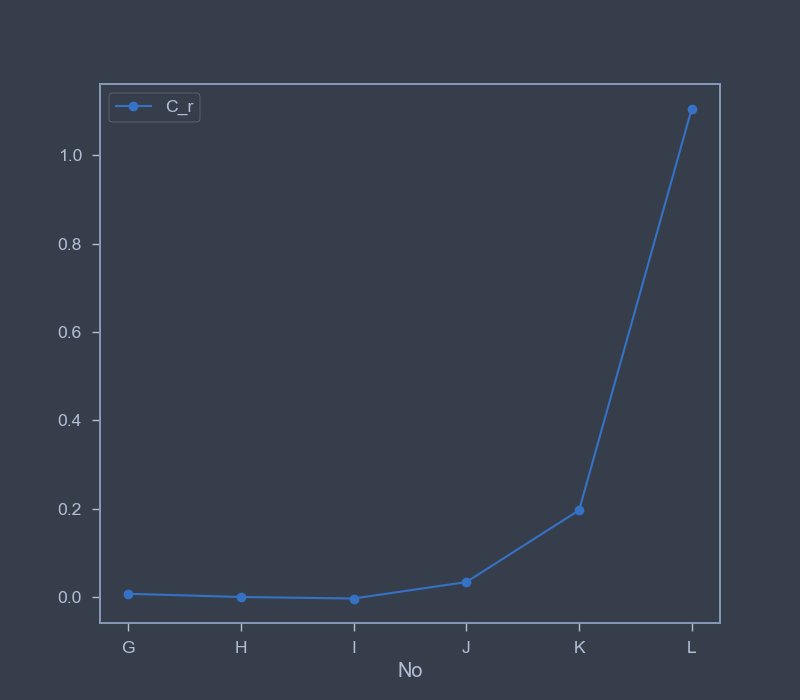

<AxesSubplot:xlabel='No'>

In [40]:
df_series60 = df.loc['G':'L'].copy()
df_series60['R'] = estimate_bilge_radius(**df_series60)

a, a_1, a_3, sigma_s, H = calculate_lewis(df_series60)
df_series60['a_1'] = a_1
df_series60['a_3'] = a_3
df_series60['H0'] = H

OG = df_series60['OG/d']*df_series60.d
ra = 1000
df_series60['C_r'] = ikeda_naked.calculate_C_r(bwl=df_series60.B,
                          a_1=a_1, a_3=a_3, sigma=df_series60.sigma, H0=H, d=df_series60.d, OG=OG, 
                          R=df_series60.R, ra=ra)

df_series60.plot(y='C_r', style='o-')

In [41]:
df_kvlcc2 = pd.read_csv('../data/interim/kvlcc_areas.csv', sep=';', index_col=0)
df_kvlcc2.rename(columns={
    'b':'B',
    't':'d',
    'r_b':'R',
}, inplace=True)
df_kvlcc2['sigma']=df_kvlcc2.area/(df_kvlcc2.B*df_kvlcc2.d)
df_kvlcc2['OG/d']=0  # For now...
#sigma_limit = 0.995
sigma_limit = 1

mask = df_kvlcc2['sigma']>sigma_limit
df_kvlcc2.loc[mask,'sigma'] = sigma_limit

df_kvlcc2.head()

,area,x,d,B,R,sigma,OG/d
no,,,,,,,
0,13.826612,-5.495000,2.00,11.638577,6.636080,0.593999,0
1,123.851306,10.159932,18.25,27.893522,42.367175,0.243296,0
2,428.211409,28.051284,20.80,41.824284,45.369454,0.492228,0
3,683.709165,43.706216,20.80,50.282514,41.080696,0.653719,0
4,917.895066,61.597568,20.80,56.159232,34.146143,0.785794,0


<IPython.core.display.Javascript object>


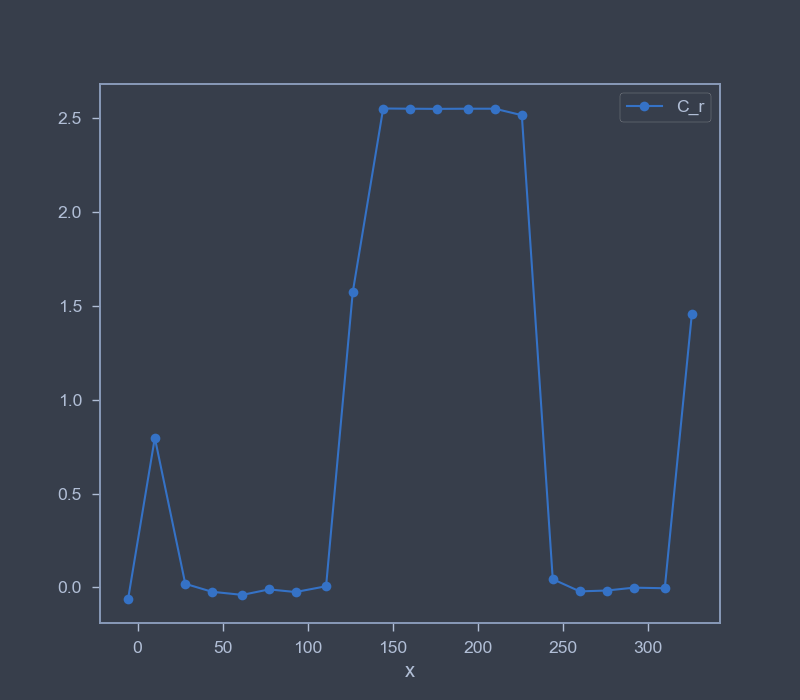

<AxesSubplot:xlabel='x'>

In [42]:
a, a_1, a_3, sigma_s, H = calculate_lewis(df_kvlcc2)
df_kvlcc2['a_1'] = a_1
df_kvlcc2['a_3'] = a_3
df_kvlcc2['H0'] = H

OG = df_kvlcc2['OG/d']*df_kvlcc2.d
ra = 1000
df_kvlcc2['C_r'] = ikeda_naked.calculate_C_r(bwl=df_kvlcc2.B,
                          a_1=df_kvlcc2.a_1, a_3=df_kvlcc2.a_3, sigma=df_kvlcc2.sigma, H0=df_kvlcc2.H0, d=df_kvlcc2.d, OG=OG, 
                          R=df_kvlcc2.R, ra=ra)

df_kvlcc2.plot(x = 'x', y='C_r', style='o-')

In [43]:
df_kvlcc2.loc[4]

area     917.895066
x         61.597568
d         20.800000
B         56.159232
R         34.146143
sigma      0.785794
OG/d       0.000000
a_1        0.148893
a_3       -0.000246
H0         1.349982
C_r       -0.039720
Name: 4, dtype: float64

In [44]:
df_kvlcc2

,area,x,d,B,R,sigma,OG/d,a_1,a_3,H0,C_r
no,,,,,,,,,,,
0,13.826612,-5.495000,2.00,11.638577,6.636080,0.593999,0,0.534095,0.093461,2.909644,-0.058939
1,123.851306,10.159932,18.25,27.893522,42.367175,0.243296,0,-0.182446,0.365057,0.764206,0.797096
2,428.211409,28.051284,20.80,41.824284,45.369454,0.492228,0,0.003204,0.191589,1.005391,0.019383
3,683.709165,43.706216,20.80,50.282514,41.080696,0.653719,0,0.102394,0.083578,1.208714,-0.023030
4,917.895066,61.597568,20.80,56.159232,34.146143,0.785794,0,0.148893,-0.000246,1.349982,-0.039720
5,1056.860933,77.252500,20.80,57.870498,26.158540,0.878006,0,0.154150,-0.057593,1.391118,-0.010557
6,1139.503552,92.907432,20.80,58.000008,17.655717,0.944549,0,0.148226,-0.099798,1.394231,-0.024462
7,1186.852794,110.798780,20.80,58.000008,9.543935,0.983797,0,0.144000,-0.125462,1.394231,0.006249
8,1203.217372,126.453720,20.80,58.000008,3.851125,0.997362,0,0.142507,-0.134532,1.394231,1.572068


In [45]:
a_1 = df_kvlcc2['a_1']
a_3 = df_kvlcc2['a_3']

1/2*np.arccos(a_1*(1+a_3)/(4*a_3))

a_1*(1+a_3)/(4*a_3)

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


no
0       1.562184
1      -0.170555
2       0.004981
3       0.331879
4    -151.141933
5      -0.630594
6      -0.334259
7      -0.250939
8      -0.229192
9      -0.228306
10     -0.228307
11     -0.228308
12     -0.228307
13     -0.228307
14     -0.228336
15     -0.238498
16     -0.268316
17     -0.306458
18     -0.218240
19      1.002427
20     -2.066534
dtype: float64

In [46]:
a, a_1, a_3, sigma_s, H = calculate_lewis(df_kvlcc2)

In [47]:
C_1 = sp.symbols('C_1')
sigma = sp.symbols('sigma')
H_0 = sp.symbols('H_0')
B = sp.symbols('B')
d = sp.symbols('d')

eq_C_1 = sp.Eq(lhs=C_1, 
               rhs = (3 + 4 * sigma / sp.pi) + (1 - 4 * sigma / sp.pi) * ((H_0 - 1) / (H_0 + 1)) ** 2)
eq_C_1

Eq(C_1, 4*sigma/pi + (H_0 - 1)**2*(-4*sigma/pi + 1)/(H_0 + 1)**2 + 3)

In [48]:
eq_H_0 = sp.Eq(lhs=H_0,
              rhs=B/(2*d))
eq_H_0

Eq(H_0, B/(2*d))

In [49]:
a_1 = sp.symbols('a_1')
a_3 = sp.symbols('a_3')

eq_a_3 = sp.Eq(lhs=a_3,
               rhs=(-C_1 + 3 + sp.sqrt(9 - 2 * C_1)) / C_1)
eq_a_3

Eq(a_3, (-C_1 + sqrt(9 - 2*C_1) + 3)/C_1)

In [50]:
eq_a_1 = sp.Eq(lhs=a_1,
               rhs=(1 + a_3) * (H_0 - 1) / (H_0 + 1))
eq_a_1

Eq(a_1, (H_0 - 1)*(a_3 + 1)/(H_0 + 1))

In [51]:
eqs = [
    eq_C_1,
    eq_a_1,
    eq_a_3,
]
solution = sp.solve(eqs,[C_1, a_1, a_3], dict=True)

In [52]:
solution[0][a_3]

(sqrt(pi)*H_0**2*sqrt((pi*H_0**2 - 32*H_0*sigma + 10*pi*H_0 + pi)/(H_0**2 + 2*H_0 + 1)) - pi*H_0**2 - 16*H_0*sigma + 2*sqrt(pi)*H_0*sqrt((pi*H_0**2 - 32*H_0*sigma + 10*pi*H_0 + pi)/(H_0**2 + 2*H_0 + 1)) + 2*pi*H_0 + sqrt(pi)*sqrt((pi*H_0**2 - 32*H_0*sigma + 10*pi*H_0 + pi)/(H_0**2 + 2*H_0 + 1)) - pi)/(4*(pi*H_0**2 + 4*H_0*sigma + pi*H_0 + pi))

In [53]:
eq_limit = sp.Eq(lhs=1,
                 rhs=a_1*(1+a_3)/(4*a_3)
                )
eq_limit

Eq(1, a_1*(a_3 + 1)/(4*a_3))

In [54]:
eq = sp.Eq(sp.solve(eq_limit,a_1)[0],
      eq_a_1.rhs)
eq

Eq(4*a_3/(a_3 + 1), (H_0 - 1)*(a_3 + 1)/(H_0 + 1))

In [55]:
sp.solve(eq,a_3)[0]

(H_0 - 2*sqrt(2*H_0 + 2) + 3)/(H_0 - 1)

In [56]:
sp.solve(eq,a_3)[1]

(H_0 + 2*sqrt(2*H_0 + 2) + 3)/(H_0 - 1)

In [57]:
lambda_a_3_limit_1 = lambdify(sp.solve(eq,a_3)[0])
lambda_a_3_limit_1

<function _lambdifygenerated(H_0)>

In [58]:
lambda_a_3_limit_2 = lambdify(sp.solve(eq,a_3)[1])
lambda_a_3_limit_2

<function _lambdifygenerated(H_0)>

In [59]:
df_kvlcc2['a_3_limit_1'] = lambda_a_3_limit_1(H_0=df_kvlcc2.H0)
df_kvlcc2['a_3_limit_2'] = lambda_a_3_limit_2(H_0=df_kvlcc2.H0)

In [60]:
df_kvlcc2['ok'] = ((df_kvlcc2['a_3'].abs() > df_kvlcc2['a_3_limit_1'].abs()) & 
 (df_kvlcc2['a_3'].abs() < df_kvlcc2['a_3_limit_2'].abs()))

In [61]:
df_kvlcc2

,area,x,d,B,R,sigma,OG/d,a_1,a_3,H0,C_r,a_3_limit_1,a_3_limit_2,ok
no,,,,,,,,,,,,,,
0,13.826612,-5.495000,2.00,11.638577,6.636080,0.593999,0,0.534095,0.093461,2.909644,-0.058939,0.166024,6.023238,False
1,123.851306,10.159932,18.25,27.893522,42.367175,0.243296,0,-0.182446,0.365057,0.764206,0.797096,-0.031351,-31.896581,True
2,428.211409,28.051284,20.80,41.824284,45.369454,0.492228,0,0.003204,0.191589,1.005391,0.019383,0.000673,1485.832324,True
3,683.709165,43.706216,20.80,50.282514,41.080696,0.653719,0,0.102394,0.083578,1.208714,-0.023030,0.024811,40.305102,True
4,917.895066,61.597568,20.80,56.159232,34.146143,0.785794,0,0.148893,-0.000246,1.349982,-0.039720,0.040293,24.818055,False
5,1056.860933,77.252500,20.80,57.870498,26.158540,0.878006,0,0.154150,-0.057593,1.391118,-0.010557,0.044624,22.409575,True
6,1139.503552,92.907432,20.80,58.000008,17.655717,0.944549,0,0.148226,-0.099798,1.394231,-0.024462,0.044948,22.247725,True
7,1186.852794,110.798780,20.80,58.000008,9.543935,0.983797,0,0.144000,-0.125462,1.394231,0.006249,0.044948,22.247725,True
8,1203.217372,126.453720,20.80,58.000008,3.851125,0.997362,0,0.142507,-0.134532,1.394231,1.572068,0.044948,22.247725,True


In [62]:
df_kvlcc2_ = df_kvlcc2.copy()
a_3_diff_1 = (df_kvlcc2_['a_3'] - df_kvlcc2_['a_3_limit_1']).abs()
a_3_diff_2 = (df_kvlcc2_['a_3'] - df_kvlcc2_['a_3_limit_2']).abs()

mask = ((~df_kvlcc2_['ok']) & (a_3_diff_1 <= a_3_diff_2))
df_kvlcc2_.loc[mask,'a_3'] = df_kvlcc2_.loc[mask,'a_3_limit_1']

mask = ((~df_kvlcc2_['ok']) & (a_3_diff_1 > a_3_diff_2))
df_kvlcc2_.loc[mask,'a_3'] = df_kvlcc2_.loc[mask,'a_3_limit_2']

df_kvlcc2_

,area,x,d,B,R,sigma,OG/d,a_1,a_3,H0,C_r,a_3_limit_1,a_3_limit_2,ok
no,,,,,,,,,,,,,,
0,13.826612,-5.495000,2.00,11.638577,6.636080,0.593999,0,0.534095,0.166024,2.909644,-0.058939,0.166024,6.023238,False
1,123.851306,10.159932,18.25,27.893522,42.367175,0.243296,0,-0.182446,0.365057,0.764206,0.797096,-0.031351,-31.896581,True
2,428.211409,28.051284,20.80,41.824284,45.369454,0.492228,0,0.003204,0.191589,1.005391,0.019383,0.000673,1485.832324,True
3,683.709165,43.706216,20.80,50.282514,41.080696,0.653719,0,0.102394,0.083578,1.208714,-0.023030,0.024811,40.305102,True
4,917.895066,61.597568,20.80,56.159232,34.146143,0.785794,0,0.148893,0.040293,1.349982,-0.039720,0.040293,24.818055,False
5,1056.860933,77.252500,20.80,57.870498,26.158540,0.878006,0,0.154150,-0.057593,1.391118,-0.010557,0.044624,22.409575,True
6,1139.503552,92.907432,20.80,58.000008,17.655717,0.944549,0,0.148226,-0.099798,1.394231,-0.024462,0.044948,22.247725,True
7,1186.852794,110.798780,20.80,58.000008,9.543935,0.983797,0,0.144000,-0.125462,1.394231,0.006249,0.044948,22.247725,True
8,1203.217372,126.453720,20.80,58.000008,3.851125,0.997362,0,0.142507,-0.134532,1.394231,1.572068,0.044948,22.247725,True


c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<IPython.core.display.Javascript object>


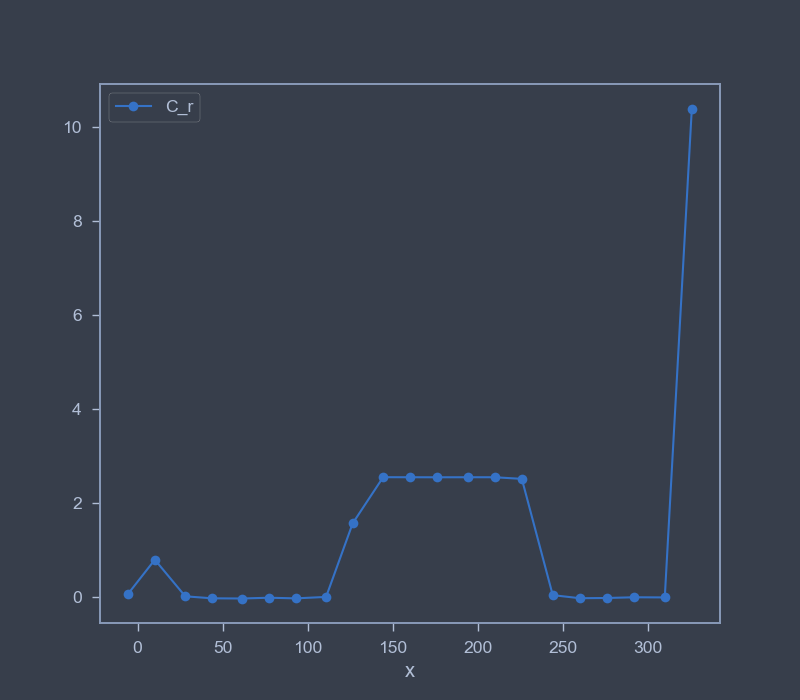

<AxesSubplot:xlabel='x'>

In [63]:
OG = df_kvlcc2_['OG/d']*df_kvlcc2_.d
ra = 1000
df_kvlcc2_['C_r'] = ikeda_naked.calculate_C_r(bwl=df_kvlcc2_.B,
                          a_1=df_kvlcc2_.a_1, a_3=df_kvlcc2_.a_3, sigma=df_kvlcc2_.sigma, 
                                              H0=df_kvlcc2_.H0, d=df_kvlcc2_.d, OG=OG, 
                          R=df_kvlcc2_.R, ra=ra)

df_kvlcc2_.plot(x = 'x', y='C_r', style='o-')

<IPython.core.display.Javascript object>


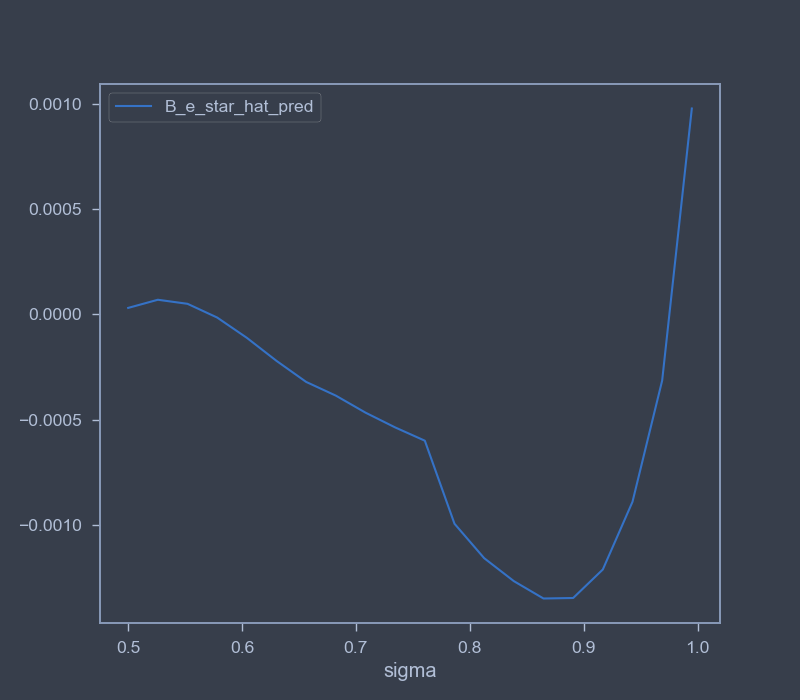

<AxesSubplot:xlabel='sigma'>

In [64]:
model = df.loc['C'].copy()
model['w_hat'] = 0.751
model['phi_a'] = 0.31

N=20
data = np.tile(model,(N,1))
df_ = pd.DataFrame(data=data, columns=model.index)
df_['sigma'] = np.linspace(1/2,model.sigma,N)

df_['B_e_star_hat_pred'] = calculate_B_star_hat(df_)
df_.set_index('sigma', inplace=True)
fig,ax=plt.subplots()
df_.plot(y='B_e_star_hat_pred', ax=ax)

<IPython.core.display.Javascript object>


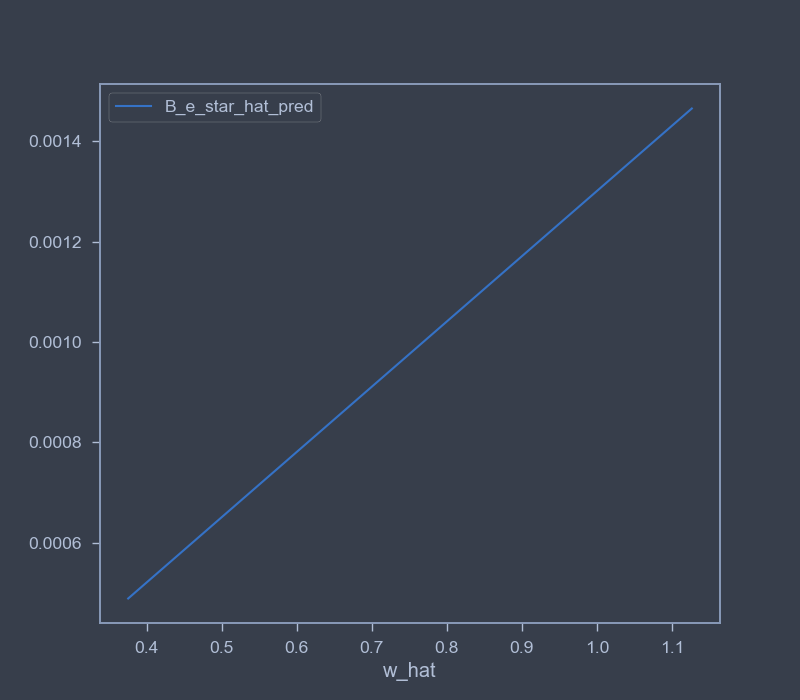

<AxesSubplot:xlabel='w_hat'>

In [65]:
model = df.loc['C'].copy()
model['w_hat'] = 0.751
model['phi_a'] = 0.31

N=20
data = np.tile(model,(N,1))
df_ = pd.DataFrame(data=data, columns=model.index)
key = 'w_hat'
df_[key] = np.linspace(0.5*model.w_hat,1.5*model.w_hat,N)

df_['B_e_star_hat_pred'] = calculate_B_star_hat(df_)
df_.set_index(key, inplace=True)
fig,ax=plt.subplots()
df_.plot(y='B_e_star_hat_pred', ax=ax)

In [66]:
from sympy.physics.mechanics import dynamicsymbols
phi = dynamicsymbols('phi')
rho = sp.symbols('rho')
r_max = sp.symbols('r_max')
C_p = sp.symbols('C_p')
C_r = sp.symbols('C_r')
P_m = sp.symbols('P_m')
d = sp.symbols('d')
H0 = sp.symbols('H0')
f_1 = sp.symbols('f_1')
f_2 = sp.symbols('f_2')
OG = sp.symbols('OG')
R = sp.symbols('OG')
M_re = sp.symbols('M_re')

eq_P_m = sp.Eq(P_m,
               3*1/2*rho*r_max**2*C_p*sp.Abs(phi.diff())*phi.diff().diff()  # (13) 
              )
eq_P_m

Eq(P_m, 1.5*C_p*r_max**2*rho*Abs(Derivative(phi(t), t))*Derivative(phi(t), (t, 2)))

In [67]:
eq_C_r = sp.Eq(C_r,
    2/(rho*d**2*sp.Abs(phi.diff())*phi.diff().diff())*((1 - f_1*R/d)*(1 - OG/d - f_1*R/d) + f_2*(H0 - f_1*R/d)**2)*P_m/3  # (10)
              )
solution1 = sp.solve((eq_C_r,
          eq_P_m),
         [P_m, C_r], dict=True)[0][C_r]

In [68]:
eq_M_re = sp.Eq(M_re,
        1/2*rho*r_max**2*d**2*C_p*((1-f_1*R/d)*(1 - OG/d - f_1*R/d) + f_2*(H0 - f_1*R/d)**2)
               )
eq_M_re

Eq(M_re, 0.5*C_p*d**2*r_max**2*rho*(f_2*(H0 - OG*f_1/d)**2 + (-OG*f_1/d + 1)*(-OG*f_1/d - OG/d + 1)))

In [69]:
eq_C_r2 = sp.Eq(C_r,
                M_re/(1/2*rho*d**4)
               )
solution2 = sp.solve((
    eq_M_re,
    eq_C_r2,
    ),
    [C_r,M_re], dict=True)[0][C_r]

In [70]:
solution1 == solution2

True